In [57]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import json
import os
from collections import Counter
import datetime as dt


In [59]:
from google.colab import files
uploaded = files.upload()

Saving trumph.csv to trumph (2).csv


In [60]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['trumph.csv']))

In [92]:
df2.head(5)

,Unnamed: 0,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Polarity
0,0,2020-07-18 23:59:56,1284639069906010113,False,parisdennard realdonaldtrump joebiden trump am...,sistermazel,NaN,Twitter for iPhone,0,0,32,0,-0.2
1,1,2020-07-18 23:59:54,1284639060544241664,False,ritapanahi http co cebqrurt j donald trump dee...,grub12321,NaN,Twitter Web App,1,21,76,0,0.0
2,2,2020-07-18 23:59:53,1284639057285394433,False,rt mayawiley nationwid mask kidnap protest thr...,QuantumHumanity,Global,Twitter Web App,0,3854,4942,3284,0.0
3,3,2020-07-18 23:59:47,1284639034522972161,False,rt howardfineman ask author whose command trum...,JohnalanJames2,"Red City, KS",Twitter for Android,0,20839,22556,13678,0.0
4,4,2020-07-18 23:59:44,1284639021654671360,False,poshtwo charliekirk god never promis send u po...,DanSmit21326682,"California, USA",Twitter for iPhone,5,2573,5001,4,0.0


In [62]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28878 entries, 0 to 28877
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  28878 non-null  int64 
 1   Date        28878 non-null  object
 2   Tweet_id    28878 non-null  int64 
 3   Verified    28878 non-null  bool  
 4   Tweet       28878 non-null  object
 5   User        28878 non-null  object
 6   Location    18738 non-null  object
 7   Source      28872 non-null  object
 8   Likes       28878 non-null  int64 
 9   Followers   28878 non-null  int64 
 10  Following   28878 non-null  int64 
 11  Retweets    28878 non-null  int64 
dtypes: bool(1), int64(6), object(5)
memory usage: 2.5+ MB


In [63]:
df2.shape

(28878, 12)

In [64]:
df2.Verified.value_counts()

False    28752
True       126
Name: Verified, dtype: int64

In [65]:
df2.Date.value_counts()

2020-07-18 17:46:04    7
2020-07-18 20:57:38    6
2020-07-18 19:37:31    5
2020-07-18 13:13:13    5
2020-07-18 23:07:05    5
                      ..
2020-07-18 22:28:16    1
2020-07-18 12:03:27    1
2020-07-18 21:55:28    1
2020-07-18 16:55:05    1
2020-07-18 21:13:07    1
Name: Date, Length: 23049, dtype: int64

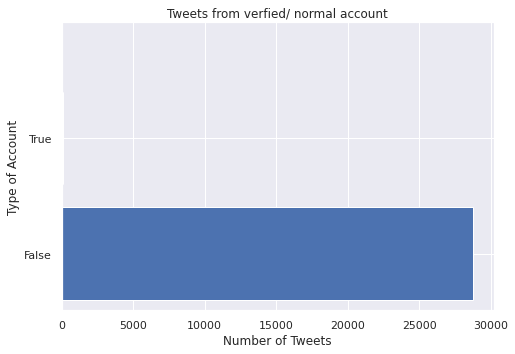

In [66]:

df2.Verified.value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
data = df2["Verified"].value_counts() 
# get x and y data 
points = data.index
frequency = data.values
#plot graph
ax.barh(points,frequency)
ax.set_yticks([0,1,2])
ax.set_yticklabels(["False","True"])
plt.xlabel("Number of Tweets")
plt.ylabel("Type of Account")
plt.title("Tweets from verfied/ normal account")
plt.show()

In [67]:
df2.Tweet_id.value_counts()

1284492531972083712    1
1284581885897842689    1
1284547215185317889    1
1284504722947416064    1
1284529644222513152    1
                      ..
1284548053110841349    1
1284530546706575364    1
1284600877635035138    1
1284636092298190848    1
1284493495005261825    1
Name: Tweet_id, Length: 28878, dtype: int64

In [68]:
df2[df2.Tweet_id==1284492531972083712]['User']

18196    nycquinn
Name: User, dtype: object

In [69]:
tweet_list=df2['Tweet'].tolist()
len(tweet_list)

28878

In [70]:
tweet_list_updated=set(tweet_list)
len(tweet_list_updated)

8902

In [71]:
tweet_list_updated= list(tweet_list_updated)
type(tweet_list_updated)

list

In [72]:
df2['Tweet'].duplicated().sum()

19976

In [73]:
df2=df2.drop_duplicates(subset='Tweet',keep='first')
df2.shape

(8902, 12)

In [94]:
df2.Verified.value_counts()

False    8811
True       91
Name: Verified, dtype: int64

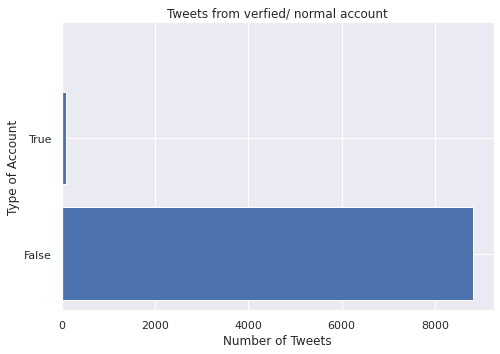

In [93]:
df2.Verified.value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# count the occurrence of each class 
data = df2["Verified"].value_counts() 
# get x and y data 
points = data.index
frequency = data.values
#plot graph
ax.barh(points,frequency)
ax.set_yticks([0,1,2])
ax.set_yticklabels(["False","True"])
plt.xlabel("Number of Tweets")
plt.ylabel("Type of Account")
plt.title("Tweets from verfied/ normal account")
plt.show()

The tweets contains many unnecessary characters like html code, emojis and urls. We need to clean our data by removing these characters before we perform sentiment analysis.

In [74]:
#removing unnecessary special characters, numbers, punctuations in a new column called clean tweets
df2.Tweet = [re.sub('[^a-zA-Z]', ' ',i) for i in df2.Tweet]

#Converting into lower case 
df2.Tweet  = [low.lower() for low in df2.Tweet ]

#Removing Emojis
def preprocess(Tweet):
    emojis = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',Tweet)
    Tweet = re.sub('[\W]+',' ', Tweet.lower()) +\
    ' '.join(emojis).replace('-','')
     
    return Tweet
    
df2.Tweet =df2.Tweet.apply(preprocess)

#Removing URLs 

df2.Tweet  = df2.Tweet.apply(lambda x: re.sub(r"https\S+", "", str(x)))
df2.Tweet.head(10)

0     parisdennard realdonaldtrump joebiden or in t...
1     ritapanahi https t co cebqrurt j donald trump...
2    rt mayawiley nationwide masked kidnappings of ...
3    rt howardfineman i ask again by what authority...
4     poshtwo charliekirk god never promised to sen...
5    rt pedal dmetals the picture below is of pelos...
6    rt alexmjordan jordansview trump s done in yea...
7    rt jack realnews truth trump trump qanon obama...
8    some fox news anchors and reporters as opposed...
9    rt andyostroy realdonaldtrump hey moron all of...
Name: Tweet, dtype: object

After removing the stopwords, the next steps performed are stemming and lemmatizations to extract the original words that are tweeted by the user and then splitting the text into individual words.

In [75]:
 from nltk.corpus import stopwords 
nltk.download('stopwords')
cachedStopWords=set(stopwords.words("english"))
print(cachedStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'your', 'while', 'most', 'having', 'who', 'to', 'which', 'doesn', 'under', 'is', 'yourself', 'of', 'yours', 'now', 'mustn', 'hasn', "you'll", 'myself', 'don', 't', 'own', "hadn't", 'be', 'themselves', 'an', 'and', 'again', 'through', 'that', 'a', 'his', 'theirs', 'out', 'into', 'off', 'no', 'their', 'haven', 'during', 'has', 'where', "doesn't", 'shouldn', 'does', 'wouldn', 'am', 'shan', 'so', "wasn't", 'them', "isn't", 'her', 'm', 'over', 'there', "you'd", 'as', 'just', 'from', 'up', "should've", 'can', 're', "it's", 'for', 'ain', 'will', 'didn', 'were', "weren't", 'both', 'until', 'y', 'ourselves', "needn't", 'him', 'was', 'on', 'at', 'only', 'being', 've', "mightn't", 'i', 'it', 'such', "haven't", 'this', 'we', 'the', 'but', 'than', 'won', 'too', 'o', 'between', 'weren', 'ours', "that'll", 'each', 'hadn', 'she', 'what', "don't", "shouldn't", 'why', "you've", 'these'

In [76]:
#Removing Stop Words
df2.Tweet=df2.Tweet.apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in cachedStopWords]))

#Stemming

porter = PorterStemmer()
def stemWords(word):
    return porter.stem(word)
        
df2["Tweet"] = df2["Tweet"].apply(lambda tweet: ' '.join([stemWords(word) for word in tweet.split()]))

In [77]:
import nltk
nltk.download('wordnet')
lema = WordNetLemmatizer()
def lemmatizeWords(word):
    return lema.lemmatize(word)
df2.Tweet = df2.Tweet.apply(lambda tweet: ' '.join([lemmatizeWords(word) for word in tweet.split()]))


#Preparing words by splitting the text
words=[]
words=[word for tweet in df2.Tweet for word in tweet.split()]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
print(words[0:100])

['parisdennard', 'realdonaldtrump', 'joebiden', 'trump', 'america', 'dead', 'choos', 'ritapanahi', 'http', 'co', 'cebqrurt', 'j', 'donald', 'trump', 'deep', 'dive', 'trump', 'aupsol', 'wwg', 'wgaworlwid', 'rt', 'mayawiley', 'nationwid', 'mask', 'kidnap', 'protest', 'thrown', 'unmark', 'van', 'trump', 'america', 'let', 'allow', 'ou', 'rt', 'howardfineman', 'ask', 'author', 'whose', 'command', 'trump', 'vigilant', 'street', 'portland', 'poshtwo', 'charliekirk', 'god', 'never', 'promis', 'send', 'u', 'polish', 'politician', 'never', 'promis', 'grace', 'u', 'pol', 'http', 'co', 'lrl', 'cvsbxu', 'rt', 'pedal', 'dmetal', 'pictur', 'pelosi', 'meet', 'privat', 'member', 'fakenewsmedia', 'includ', 'foxnewssunday', 'chri', 'wallac', 'rt', 'alexmjordan', 'jordansview', 'trump', 'done', 'year', 'biden', 'tl', 'brixea', 'karenl', 'bcn', 'eva', 'rodhilli', 'rt', 'jack', 'realnew', 'truth', 'trump', 'trump', 'qanon', 'obamag', 'best', 'news', 'day', 'fox']


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Definining the vectorizer 
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100).fit(df2.Tweet)

# Transform the vectorizer
X_txt = vect.transform(df2.Tweet)

# Transforming to a data frame 
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

,administr,america,american,amp,anoth,back,believ,biden,call,campaign,china,cnn,co,coronaviru,countri,covid,day,death,democrat,die,donald,elect,even,feder,follow,get,go,golf,good,gop,great,happen,http,joebiden,john,johnlewi,kill,know,let,lewi,lie,like,live,look,maga,make,man,mask,must,need,never,new,news,one,order,pandem,peopl,plea,polic,polit,portland,potu,presid,protest,racist,read,realdonaldtrump,realli,remov,republican,right,rt,said,say,see,show,state,still,stop,support,take,tell,th,thing,think,time,today,tri,trump,tweet,usa,use,viru,vote,want,way,white,whitehous,world,would
0,0.0,0.565282,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.662543,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.455595,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.236421,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.820837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.235498,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.463543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.407662,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.498124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491461,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.522915,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.230361,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.860333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.441581,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.135467,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.134938,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.98155,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.837566,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.473291,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [80]:
from textblob import TextBlob

In [81]:
pol=[]
for Tweet in df2.Tweet:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)


In [82]:
df2['Polarity']=pol
df2.head(10)


,Unnamed: 0,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Polarity
0,0,2020-07-18 23:59:56,1284639069906010113,False,parisdennard realdonaldtrump joebiden trump am...,sistermazel,NaN,Twitter for iPhone,0,0,32,0,-0.200
1,1,2020-07-18 23:59:54,1284639060544241664,False,ritapanahi http co cebqrurt j donald trump dee...,grub12321,NaN,Twitter Web App,1,21,76,0,0.000
2,2,2020-07-18 23:59:53,1284639057285394433,False,rt mayawiley nationwid mask kidnap protest thr...,QuantumHumanity,Global,Twitter Web App,0,3854,4942,3284,0.000
3,3,2020-07-18 23:59:47,1284639034522972161,False,rt howardfineman ask author whose command trum...,JohnalanJames2,"Red City, KS",Twitter for Android,0,20839,22556,13678,0.000
4,4,2020-07-18 23:59:44,1284639021654671360,False,poshtwo charliekirk god never promis send u po...,DanSmit21326682,"California, USA",Twitter for iPhone,5,2573,5001,4,0.000
5,5,2020-07-18 23:59:40,1284639004504334336,False,rt pedal dmetal pictur pelosi meet privat memb...,2Illiberalality,NaN,Twitter Web App,0,611,692,1443,0.000
6,6,2020-07-18 23:59:40,1284639004139442176,False,rt alexmjordan jordansview trump done year bid...,Unyielding5,NaN,Twitter for Android,0,22029,22135,265,0.000
7,7,2020-07-18 23:59:38,1284638995306237954,False,rt jack realnew truth trump trump qanon obamag...,Honeybeehive4b1,USA,Twitter for Android,0,1802,1810,2,1.000
8,8,2020-07-18 23:59:31,1284638965308350464,False,fox news anchor report oppos talk show host be...,FrankPKing,"Coronado, CA",Twitter for Android,2,7958,8336,1,0.000
9,9,2020-07-18 23:59:26,1284638945460883456,False,rt andyostroy realdonaldtrump hey moron dark d...,Patricia99801,NaN,Twitter for iPhone,0,1031,5001,338,-0.475


In [83]:
positive=0
negative=0
neutral=0
for pol in df2.Polarity:
    if pol>0:
        positive+=1
    elif pol<0:
        negative+=1
    else:
        neutral+=1
print("Positve Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positve Tweets: 2367
Negative Tweets: 1584
Neutral Tweets 4951


In [84]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [85]:

sid = SentimentIntensityAnalyzer()
sentiment_scores = df2.Tweet.apply(lambda x: sid.polarity_scores(x))
sentimental_score = pd.DataFrame(list(sentiment_scores))
sentimental_score.tail()


,neg,neu,pos,compound
8897,0.744,0.256,0.000,-0.4404
8898,0.133,0.867,0.000,-0.2500
8899,0.148,0.769,0.082,-0.2960
8900,0.323,0.677,0.000,-0.7351
8901,0.000,0.838,0.162,0.4019


In [86]:
sentimental_score['val'] = sentimental_score['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sentimental_score.head()

,neg,neu,pos,compound,val
0,0.417,0.583,0.000,-0.6486,negative
1,0.000,1.000,0.000,0.0000,neutral
2,0.126,0.755,0.119,-0.0258,negative
3,0.000,0.841,0.159,0.1779,positive
4,0.127,0.760,0.114,-0.0598,negative


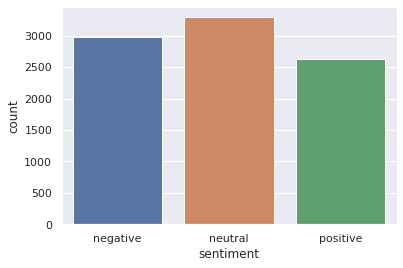

In [87]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [88]:
sentiments_time = pd.DataFrame()
sentiments_time['time'] = df2['Date']
sentiments_time['polarity'] = sentimental_score['compound']
sentiments_time.index = pd.to_datetime(sentiments_time['time'])

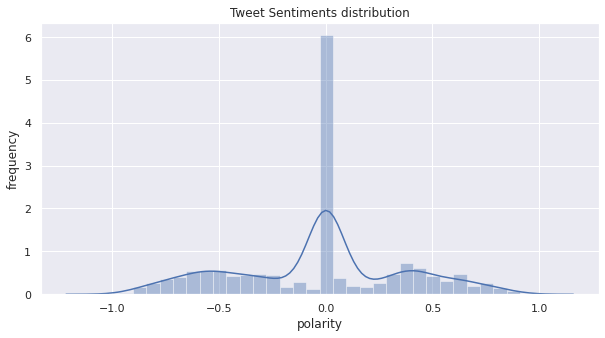

In [89]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set(title='Tweet Sentiments distribution', xlabel='polarity', ylabel='frequency')
sns.distplot(sentiments_time['polarity'], bins=30, ax=ax)

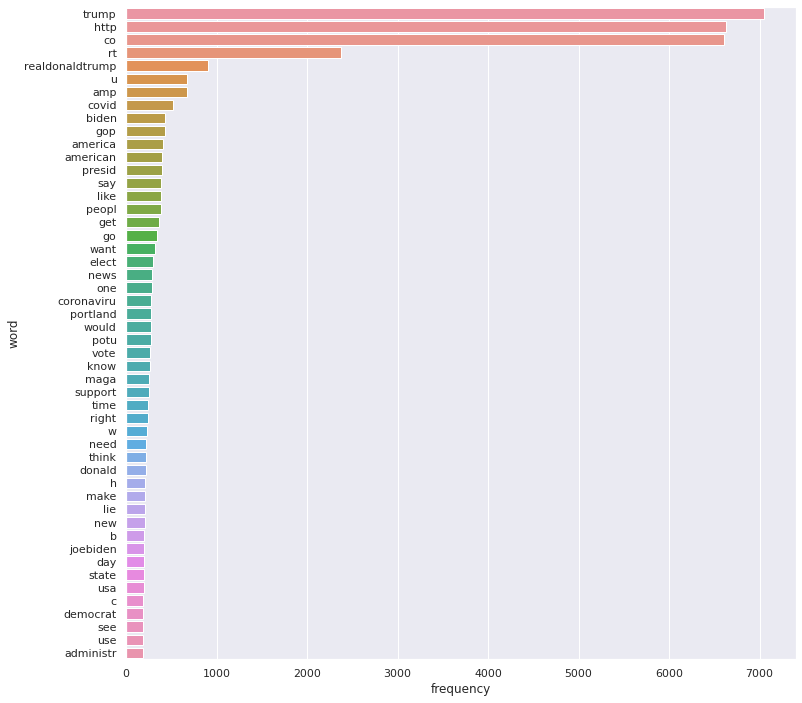

In [90]:
sns.set(style="darkgrid")
counts = Counter(words).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)

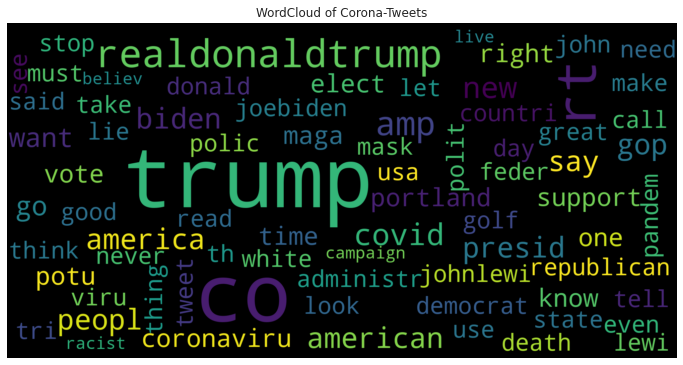

In [91]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color='black',max_words=75,max_font_size=50,scale=5,collocations=False,
                      normalize_plurals=True).generate(' '.join(words))
                       
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Corona-Tweets")
plt.show()


From the sentiment analysis and the visualizations plots made, we can conclude that the people are more neutral and negative attitude towards tTrump. 